# CSII 2023 Exercise 06: Discrete Time Stability /State Space Representation
References:

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$.

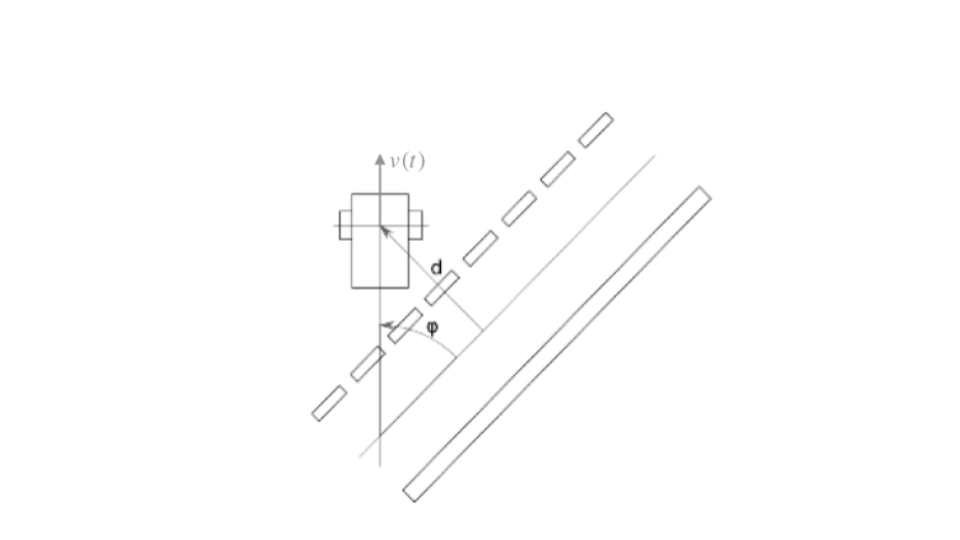

-------

## Installation
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.

If you have done all the Jupyter Notebooks leading up to this one, you should have all the necessary libraries installed. 



In [44]:
# Install the required python library with pip
!pip install control

-------

## Python Libraries

We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [45]:
# Import the required python libraries
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [46]:
# Function: unicycle_update
# Description: Computes the derivative of the state for a unicycle model.
# Input:
#   - t: float, the current time.
#   - x: np.array, the current state vector [x, y, theta].
#   - u: np.array, the input vector [v, w] where v is the forward velocity and w is the angular speed.
#   - params: dict, optional parameters for the unicycle model. It contains the maximum angular speed (max_omega).
# Output:
#   - np.array, the derivative of the state vector [xdot, ydot, thetadot].
# Variables:
#   - max_omega: float, the maximum angular speed allowed for the unicycle.
#   - omega: float, the clipped angular speed based on the maximum angular speed.
# Functionality: The function computes the derivative of the state vector for a unicycle model. It uses the input vector
#                to calculate the forward velocity (v*cos(theta), v*sin(theta)) and the angular speed (w). The angular speed
#                is clipped to the maximum angular speed specified in the parameters. The function returns the derivative
#                of the state vector [xdot, ydot, thetadot].
def unicycle_update(t: float, x: np.array, u: np.array, params: dict) -> np.array:
    max_omega = params.get("max_omega", 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v*cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v*sin(theta)
        omega                   # thetadot = w
    ])


# Function: unicycle_output
# Description: Computes the output of the unicycle model.
# Input:
#   - t: float, the current time.
#   - x: np.array, the current state vector [x, y, theta].
#   - u: np.array, the input vector [v, w] where v is the forward velocity and w is the angular speed.
#   - params: dict, optional parameters for the unicycle model.
# Output:
#   - np.array, the output vector [x, y].
# Functionality: The function computes the output of the unicycle model. It returns the position vector [x, y] from the
#                state vector [x, y, theta].
def unicycle_output(t: float, x: np.array, u: np.array, params: dict) -> np.array:
    return x[0:2]

## Plotting

The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [47]:
# Function: plot_track
# Description: Plots the trajectory, lateral position, and control input of a reference and controller system.
# Input:
#   - x_coord_ref: np.array, the x-coordinate of the reference trajectory.
#   - y_coord_ref: np.array, the y-coordinate of the reference trajectory.
#   - theta_ref: np.array, the angle of the reference trajectory.
#   - t: np.array, the time vector.
#   - w_curvy: np.array, the angular velocity of the reference trajectory.
#   - y_ctr: Optional[np.array], the lateral position of the controller trajectory (default: None).
#   - w_ctr: Optional[np.array], the angular velocity of the controller trajectory (default: None).
# Output: None
# Variables:
#   - None
# Functionality: This function plots the trajectory, lateral position, and control input of a reference and actual system.
#                The function plots the reference trajectory, and if provided, the
#                acutal trajectory. It also plots the lateral position and control input over time.
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: np.array,
               w_curvy: np.array,
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout.
    plt.figure(figsize=[9, 4.5])

    # Plot the resulting trajectory (and some road boundaries).
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(["reference"])

    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, "r", linewidth=1)
        plt.legend(["reference", "controller"])

    else:
        plt.legend(["reference"])

    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, "k-", linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, "k--", linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, "k-", linewidth=1)

    plt.xlabel("y [m]")
    plt.ylabel("x [m]");
    plt.axis("Equal")

    # Plot the lateral position.
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)

    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, "r")
        plt.legend(["reference", "controller"])

    else:
        plt.legend(["reference"])

    plt.ylabel("Lateral position $y$ [m]")

    # Plot the control input.
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, "r")
        plt.legend(["reference", "controller"])
        
    else:
        plt.legend(["reference"])

    plt.ylabel("$\\omega$ [rad/s]")
    plt.xlabel("Time t [sec]")
    plt.tight_layout()
    
    
# Function: plot_poles
# Description: Plots the poles of a system.
# Input:
#   - sys: ct.StateSpace, the system to plot the poles of.
#   - title_string: str, the title of the plot.
# Output: None
# Variables:
#   - None
# Functionality: This function plots the poles of a system in the complex plane. 

def plot_poles(sys: ct.StateSpace, title_string: str) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    ct.pzmap(sys, plot=True, title=title_string)
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.axis('Equal')
    



## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library. 

In [48]:
# Default Duckiebot velocity in m/s.
duckie_params={"velocity": 0.1, "max_omega": 0.05}

# Define the Duckiebot's steering dynamics as an input/output system.
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name="duckiebot",
    inputs=("v", "w"), outputs=("x", "y"), params=duckie_params)

v0 = duckie_params["velocity"]

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

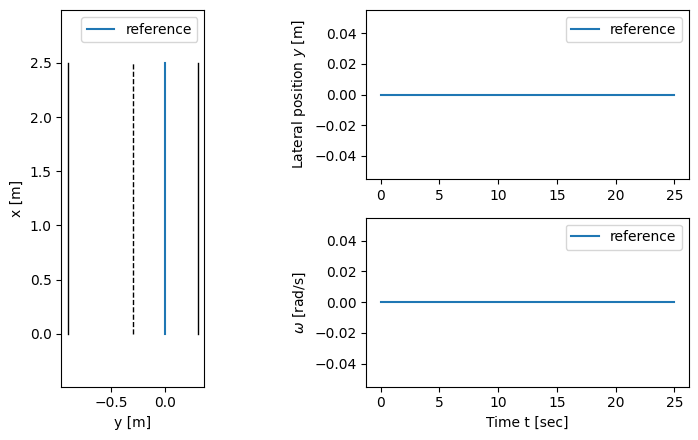

In [49]:
# Control inputs.

curve_difficulty_levels = ["easy", "hard", "straight"]
curve_difficulty = curve_difficulty_levels[2]

T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=="easy":
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)

elif curve_difficulty=="hard":
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)

else:
    # Modify this function to create your own reference track.
    w_curvy = np.zeros(T_curvy.shape)
    
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator.
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

# FILEPATH: /d:/6CS2Private/control2JN/CS2_2024_unicycle_MIMO_Stability.ipynb
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [50]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics.

lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get("velocity", 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get("velocity", 1), u[0]], params)[1:],
    states=2, name="lateral", inputs=("w"), outputs=("y")
)

# Compute the linearization at velocity v0 = 0.1 m/sec.
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use.
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[111]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



--------
## Exercise 1a:


Derive the system matrices for a discrete time system using Euler Forward discretization. That means, turn the continous time system $\dot x = A_C x+B_C u$ into discrete time $x[n+1]=A_D x[n] + B_D u[n]$.

## Hint: 
Euler Forward has the following discretization scheme: 
$$ A_D = (\mathbb{I} + T_s A_C) $$
$$ B_D = T_s B_C $$

You may use ```ct.ss()``` to make the system.

In [51]:
# Define the sampling time.
# TODO

# Compute the discrete-time system matrices.
# TODO

# Create a discrete-time state-space system.

## Solution 1a:

In [52]:
# Define the sampling time Ts
Ts = 0.1

# Compute the discrete-time system matrices
Ad = np.eye(2) + Ts * A
eigenvalues = np.linalg.eigvals(Ad)
print(eigenvalues)
Bd = Ts * B
Cd = C

syseulerforward = ct.ss(Ad, Bd, Cd, 0, dt=Ts)

[1. 1.]


## Exercise 1b:
Plot the step response for the discretized system. 

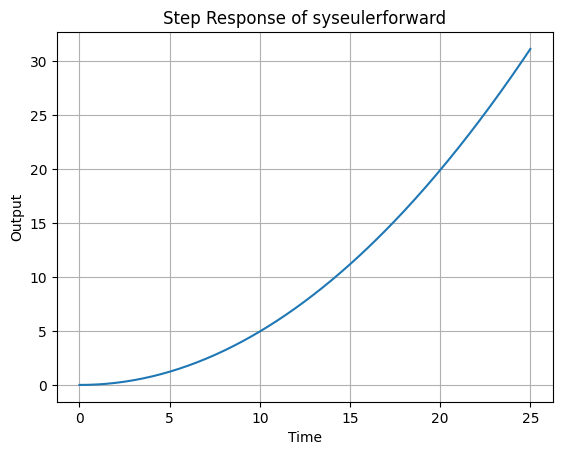

In [53]:
t, y = ct.step_response(syseulerforward)
plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Step Response of syseulerforward')
plt.grid(True)
plt.show()


------

## Exercise 2:

Discretize the System with Control library ?

Use control functions to make Euler forward/backward/Tustin/Zero-Order-Hold using Ts=0.1s and plot the poles. What is the effect on stability?

**Hints**:
* You can visualize the poles by using: ` ct.pzmap(sys, Plot=True)`  
* Using the Control library, a system can be discretized using (for more Information see [here](https://python-control.readthedocs.io/en/latest/generated/control.TransferFunction.html) ): ` sys_discrete = sys_continuous.sample_system(Ts, method='method')`


In [54]:
def system_discretization_euler_forward(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    #TODO: Implement the forward Euler discretization
    
    return sysd_forward_euler

def system_discretization_euler_backward(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    #TODO: Implement the backward Euler discretization
    
    return sysd_backward_euler

def system_discretization_tustin(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    #TODO: Implement the Tustin discretization
    
    return sysd_tustin

def system_discretization_zoh(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    #TODO: Implement the Zero Order Hold discretization
    
    return sysd_zoh

## Solution Exercise 2

In [55]:
def system_discretization_euler_forward_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss2tf(A, B, C, D)
    sysd_forward_euler = sysc.sample(Ts = 0.1, method='euler')
    
    return sysd_forward_euler

def system_discretization_euler_backward_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss(A, B, C, D)
    sysd_backward_euler = sysc.sample(Ts = 0.1, method='backward_diff')
    
    return sysd_backward_euler

def system_discretization_tustin_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss(A, B, C, D)
    sysd_tustin = sysc.sample(Ts = 0.1, method='tustin')
    
    #Alternatively, you can use the following command:
    # sysd_tustin = ct.sample_system(sysc, Ts = 0.1, method='tustin')
    
    return sysd_tustin

def system_discretization_zoh_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss(A, B, C, D)
    sysd_zoh = sysc.sample(Ts = 0.1, method='zoh')
    
    #Alternatively, you can use the following command:
    #sysd_zoh = ct.sample_system(sysc, Ts = 0.1, method='zoh')
    
    return sysd_zoh

def system_discretization_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array, np.array, np.array]:
    
    sysd_forward_euler = system_discretization_euler_forward_sol(A, B, C, D, dt)
    
    sysd_backwards_euler = system_discretization_euler_backward_sol(A, B, C, D, dt)
    
    sysd_tustin = system_discretization_tustin_sol(A, B, C, D, dt)
    
    sysd_zoh = system_discretization_zoh_sol(A, B, C, D, dt)
    
    return [sysd_forward_euler, sysd_backwards_euler, sysd_tustin, sysd_zoh]


## Exercise 2: Test your code

Forward Euler:

Backward Euler:

Tustin:

Zero Order Hold:



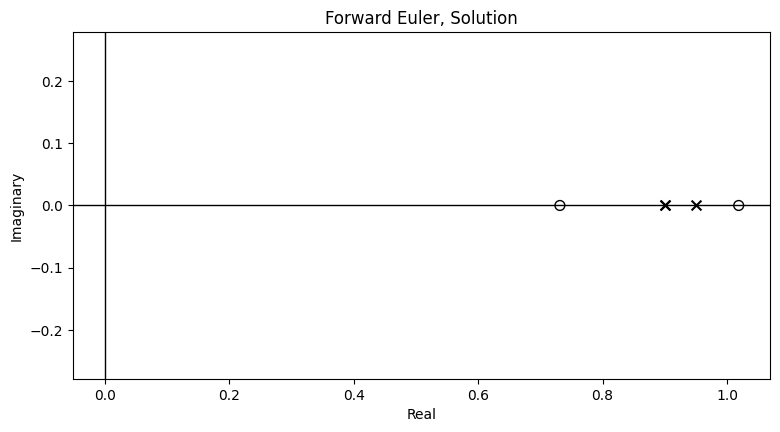

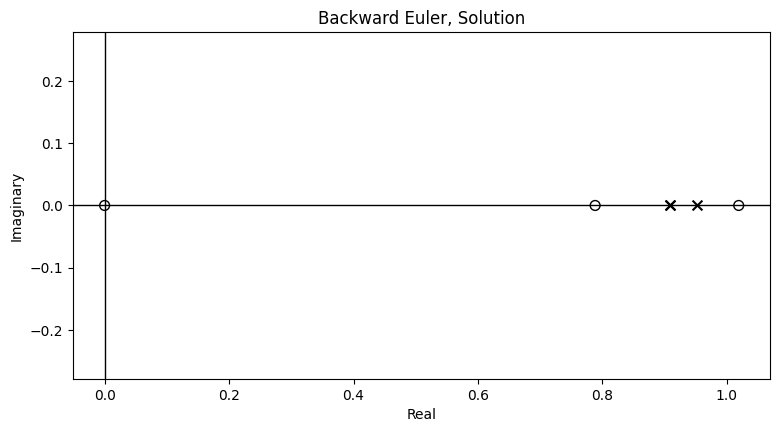

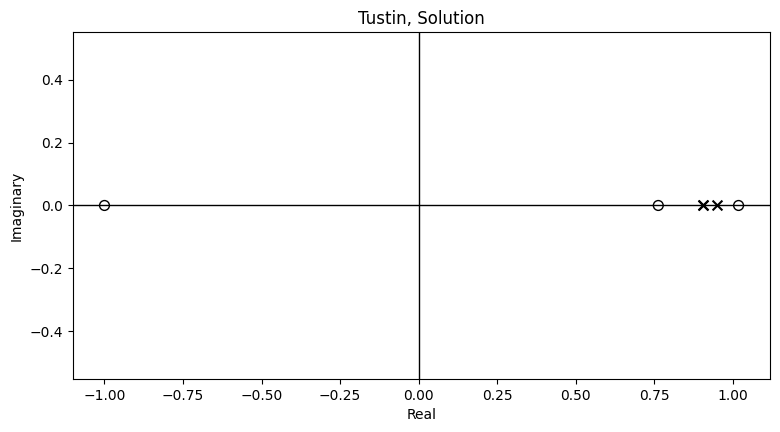

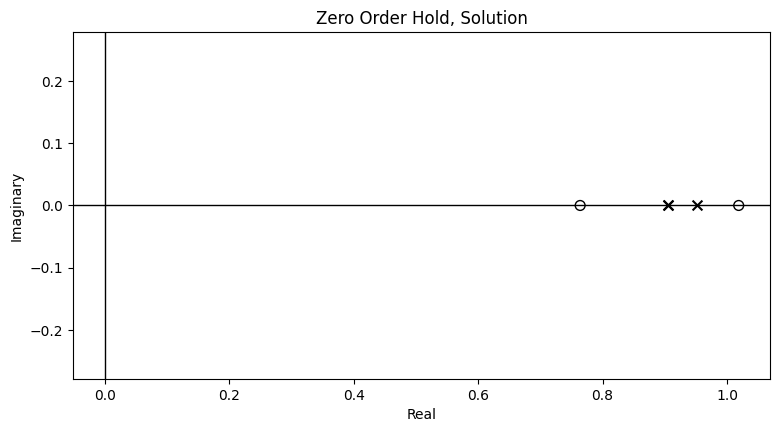

In [66]:
# Define the System matrices
A_test = np.array([[0, -2, -1], [1, 3, 1], [0.5, -1, 0.5]]) #Needs a more interesting A matrix
B_test = np.array([[1], [0], [0]])
C_test = np.array([[1, 0, 0]])
D_test = np.array([[0]])

# Define the sampling time
Ts = 0.1

solutions = system_discretization_sol(A_test, B_test, C_test, D_test, Ts)

print("Forward Euler:\n")
#sysd_forward_euler = system_discretization_euler_forward(A_test, B_test, C_test, D_test, Ts)

#plot_poles(sysd_forward_euler, t, r, 'Forward Euler, Your Implementation')
plot_poles(solutions[0], 'Forward Euler, Solution')

print("Backward Euler:\n")
#sysd_backward_euler = system_discretization_euler_backward(A_test, B_test, C_test, D_test, Ts)

#plot_poles(sysd_backward_euler, t, r, 'Backward Euler, Your Implementation')
plot_poles(solutions[1], 'Backward Euler, Solution')

print("Tustin:\n")
#sysd_tustin = system_discretization_tustin(A_test, B_test, C_test, D_test, Ts)

#plot_poles(sysd_tustin, t, r, 'Tustin, Your Implementation')
plot_poles(solutions[2], 'Tustin, Solution')

print("Zero Order Hold:\n")
#sysd_zoh = system_discretization_zoh(A_test, B_test, C_test, D_test, Ts)

#plot_poles(sysd_zoh, t, r, 'Zero Order Hold, Your Implementation')
plot_poles(solutions[3], 'Zero Order Hold, Solution')


Discretization Possible Exercises

- Plot a zero order hold
- Discretization Forward Euler
- Discretization Forward Euler using explicit I+A*Ts formula (plot how eigenvalues change with Ts)
- Discretization Backward Euler/Tustin
- Plotting continous vs discretized poles
- Sampling Rate

1) Example 1: Plot what a zero-order hold looks like

2) Exercise 1: Derive and create an LTID system using Euler Forward

3) Exercise 2: Use control functions to make Euler forward/backward/Tustin and plot the poles. What is the effect on stability

4) Exercise 3: Use some different controllers and compare the different discretization schemes